In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from datetime import date, timedelta

import mechafil.data as mecha_data
import mechafil.data_spacescope as data_spacescope
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, setup_spacescope

import mechafil.power as np_power
import mechafil_jax.power as jax_power

import mechafil.minting as np_minting
import mechafil_jax.minting as jax_minting

import matplotlib.pyplot as plt

In [3]:
setup_spacescope('/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json')

In [4]:
forecast_length = 360*2
start_date = date(2021, 3, 16)
current_date = date.today() - timedelta(days=2)
end_date = current_date + timedelta(days=forecast_length)

In [5]:
# Get sector scheduled expirations
res = get_sector_expiration_stats(start_date, current_date, end_date)
rb_known_scheduled_expire_vec = res[0]
qa_known_scheduled_expire_vec = res[1]
known_scheduled_pledge_release_full_vec = res[2]
# Get daily stats
fil_stats_df = get_historical_network_stats(start_date, current_date, end_date)
current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
# Forecast power stats
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

In [6]:
rbp = 3
rr = 0.3
fpr = 0.3
duration = 360

In [7]:
mechafil_rb_df, mechafil_qa_df = np_power.forecast_power_stats(
    rb_power_zero,
    qa_power_zero,
    rbp,
    rb_known_scheduled_expire_vec,
    qa_known_scheduled_expire_vec,
    rr,
    fpr,
    duration,
    forecast_length,
    qap_method='basic'
)

In [8]:
mechafil_rb_df["total_raw_power_eib"] = mechafil_rb_df["total_power"] / 1024.0
mechafil_qa_df["total_qa_power_eib"] = mechafil_qa_df["total_power"] / 1024.0
power_df = np_power.build_full_power_stats_df(
    fil_stats_df,
    mechafil_rb_df,
    mechafil_qa_df,
    start_date,
    current_date,
    end_date,
)

rb_total_power_eib = power_df["total_raw_power_eib"].values
qa_total_power_eib = power_df["total_qa_power_eib"].values
qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

In [9]:
np_minting_df = np_minting.compute_minting_trajectory_df(
    start_date,
    end_date,
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
    minting_base = 'RBP'
)

3.023794578546229e+20


In [10]:
zero_cum_capped_power = mecha_data.get_cum_capped_rb_power(start_date)
init_baseline = mecha_data.get_storage_baseline_value(start_date)

In [11]:
print(zero_cum_capped_power, init_baseline)

3.023794578546229e+20 4.256433910003973e+18


In [18]:
jax_minting_dict = jax_minting.compute_minting_trajectory_df(
    np.datetime64(start_date),
    np.datetime64(end_date),
    rb_total_power_eib,
    qa_total_power_eib,
    qa_day_onboarded_power_pib,
    qa_day_renewed_power_pib,
    zero_cum_capped_power/2**60,
    init_baseline/2**60
)

<IPython.core.display.Javascript object>


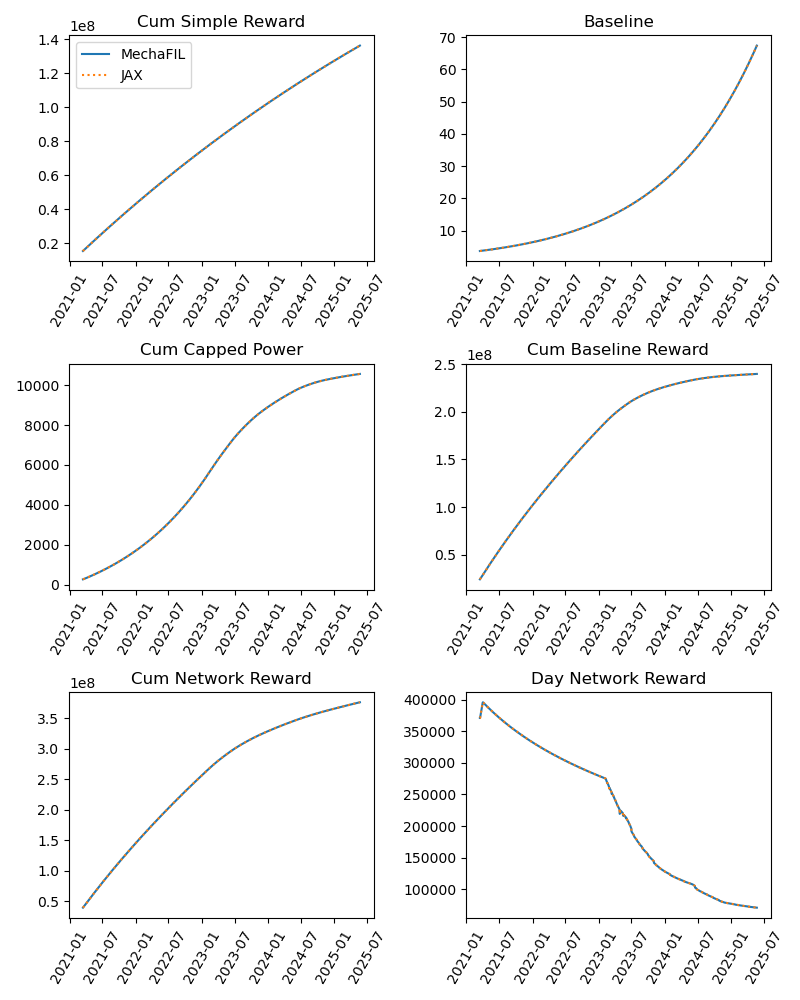

In [20]:
plt.figure(figsize=(8,10))
plt_err = False

plt.subplot(3,2,1)
if not plt_err:
    plt.plot(np_minting_df['date'], np_minting_df['cum_simple_reward'], label='MechaFIL')
    plt.plot(jax_minting_dict['date'], jax_minting_dict['cum_simple_reward'], label='JAX', linestyle=':')
else:
    plt.plot(jax_minting_dict['date'], jax_minting_dict['cum_simple_reward']-np_minting_df['cum_simple_reward'])
plt.xticks(rotation=60)
plt.legend()
plt.title('Cum Simple Reward')

plt.subplot(3,2,2)
if not plt_err:
    plt.plot(np_minting_df['date'], np_minting_df['network_baseline']/2**60, label='MechaFIL')
    plt.plot(jax_minting_dict['date'], jax_minting_dict['network_baseline_EIB'], label='JAX', linestyle=':')
else:
    plt.plot(jax_minting_dict['date'], jax_minting_dict['network_baseline_EIB']-np_minting_df['network_baseline']/2**60)
plt.xticks(rotation=60)
plt.title('Baseline')

plt.subplot(3,2,3)
if not plt_err:
    plt.plot(np_minting_df['date'], np_minting_df['cum_capped_power']/2**60, label='MechaFIL')
    plt.plot(jax_minting_dict['date'], jax_minting_dict['cum_capped_power_EIB'], label='JAX', linestyle=':')
else:
    plt.plot(jax_minting_dict['date'], jax_minting_dict['cum_capped_power_EIB']-np_minting_df['cum_capped_power']/2**60)
plt.xticks(rotation=60)
plt.title('Cum Capped Power')

plt.subplot(3,2,4)
if not plt_err:
    plt.plot(np_minting_df['date'], np_minting_df['cum_baseline_reward'], label='MechaFIL')
    plt.plot(jax_minting_dict['date'], jax_minting_dict['cum_baseline_reward'], label='JAX', linestyle=':')
else:
    plt.plot(jax_minting_dict['date'], jax_minting_dict['cum_baseline_reward']-np_minting_df['cum_baseline_reward'])
plt.xticks(rotation=60)
plt.title('Cum Baseline Reward')

plt.subplot(3,2,5)
if not plt_err:
    plt.plot(np_minting_df['date'], np_minting_df['cum_network_reward'], label='MechaFIL')
    plt.plot(jax_minting_dict['date'], jax_minting_dict['cum_network_reward'], label='JAX', linestyle=':')
else:
    plt.plot(jax_minting_dict['date'], jax_minting_dict['cum_network_reward']-np_minting_df['cum_network_reward'])
plt.xticks(rotation=60)
plt.title('Cum Network Reward')

plt.subplot(3,2,6)
if not plt_err:
    plt.plot(np_minting_df['date'], np_minting_df['day_network_reward'], label='MechaFIL')
    plt.plot(jax_minting_dict['date'], jax_minting_dict['day_network_reward'], label='JAX', linestyle=':')
else:
    plt.plot(jax_minting_dict['date'], jax_minting_dict['day_network_reward']-np_minting_df['day_network_reward'])
plt.xticks(rotation=60)
plt.title('Day Network Reward')

plt.tight_layout()